In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaewon2do","key":"e52a891c18fd5084ab8f9210e2a9e8f7"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c playground-series-s3e2

  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 79.1MB/s]


In [5]:
!ls

kaggle.json  playground-series-s3e2.zip  sample_data


In [6]:
!unzip playground-series-s3e2.zip

Archive:  playground-series-s3e2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
# For each id in the test set, you must predict the probability for the target variable stroke.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# 훈련 데이터 전처리

In [8]:
train # hyptertension은 고혈압, avg_glucose_level은 혈당 수치

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [10]:
train = train.drop_duplicates() # 중복값 없음.
train.shape

(15304, 12)

In [11]:
# Dtype이 object인 것은 describe로 단순 통계를 확인할 수 없음. -> unique로 어떤 값을 가지는지 알아볼 것.
for p in train.columns:
    if train[p].dtype == object:
        print("특성 {}는 {}값을 갖는다.".format(p, train[p].unique()))

특성 gender는 ['Male' 'Female' 'Other']값을 갖는다.
특성 ever_married는 ['Yes' 'No']값을 갖는다.
특성 work_type는 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']값을 갖는다.
특성 Residence_type는 ['Urban' 'Rural']값을 갖는다.
특성 smoking_status는 ['never smoked' 'formerly smoked' 'Unknown' 'smokes']값을 갖는다.


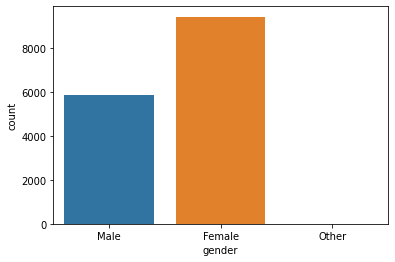

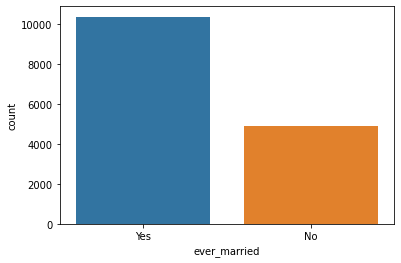

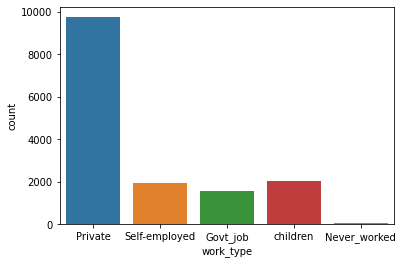

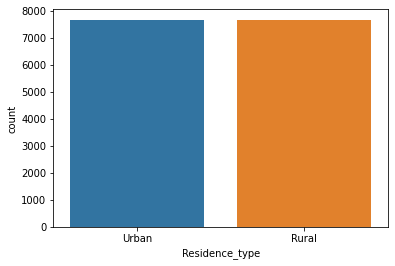

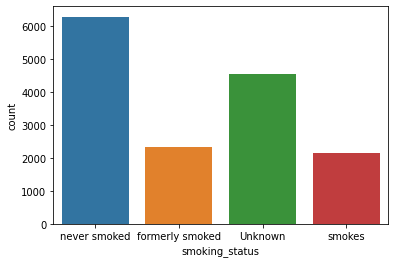

In [12]:
for p in train.columns:
    if train[p].dtype == object:
        fig = plt.figure()
        sns.countplot(x=p, data = train)
        fig

# 일단 ever_married, residence_type는 레이블 인코딩을 해도 괜찮다.
# gender의 "Other"와 smoking_status의 "Unknown"는 결측값 처리 해야함.

In [13]:
train.describe()
# age에서의 min값이 0.08 -> 정수로 떨어지지 않는 age 값을 결측값으로 간주하여 처리한다.

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


* 값이 두개인 특성은 (int64)hypertension, heart_disease, stroke, (object)ever_married, Residence_type이다.

    -> ever_married, Residence_type는 레이블 인코딩해준다.

    -> work_type는 원핫인코딩해준다.

*  정수로 떨어지지 않는 값을 가진 age, "Other"값을 갖는 gender, "Unknown"값을 갖는 smoking_status를 결측값 처리해야 한다.

* 추가적으로 맥락상 모순되는 값을 갖는 결측값이 존재하는지 확인.

* 데이터 분석에 아무런 영향을 주지 않는 정보 삭제할 것.

인코딩 유형 출처: https://hye-z.tistory.com/m/16

In [14]:
# 수치형 데이터로 처리 가능한 범주형 데이터 : ever_married, Residence_type, work_type
# 수치형 데이터 처리 전 결측치 처리해야하는 데이터 : gender, smoking_status

from sklearn.preprocessing import LabelEncoder

ever_married_answer = train['ever_married'].unique()
encoder = LabelEncoder()
encoder.fit(ever_married_answer)
train['ever_married'] = encoder.transform(train['ever_married'])
print(ever_married_answer, encoder.transform(ever_married_answer))

Residence_type = train['Residence_type'].unique()
encoder = LabelEncoder()
encoder.fit(Residence_type)
train['Residence_type'] = encoder.transform(train['Residence_type'])
print(Residence_type, encoder.transform(Residence_type))

work_type = train['work_type'].unique()
encoder = LabelEncoder()
encoder.fit(work_type)
train['work_type'] = encoder.transform(train['work_type'])
print(work_type, encoder.transform(work_type))

# print("특성 ever_married는 {}값을 갖고 dtype은 {}이다.".format(train.ever_married.unique(), train['ever_married'].dtype))
# print("특성 Residence_type는 {}값을 갖고 dtype은 {}이다.".format(train.Residence_type.unique(), train['Residence_type'].dtype))

['Yes' 'No'] [1 0]
['Urban' 'Rural'] [1 0]
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] [2 3 0 4 1]


In [15]:
work_type_checker = pd.DataFrame(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'], [2, 3, 0, 4, 1], columns = ['work_type'])
work_type_checker

,work_type
2,Private
3,Self-employed
0,Govt_job
4,children
1,Never_worked


In [16]:
train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,1,2,1,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,1,2,0,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,1,2,0,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,1,2,1,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,0,2,0,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,Female,22.0,0,0,0,0,1,72.63,19.5,never smoked,0
15300,15300,Female,46.0,1,0,1,2,1,101.19,32.1,never smoked,0
15301,15301,Female,75.0,0,0,1,3,1,87.69,26.2,never smoked,0
15302,15302,Male,46.0,0,0,1,2,0,101.13,22.5,Unknown,0


결측치 유형과 처리 기준 : https://junklee.tistory.com/4

1.  age 결측 데이터 처리

In [17]:
float_age = []

for i in train.index:
    if train.loc[i,'age'] - int(train.loc[i,'age']) > 0:
        float_age.append(i)

old_shape = train.shape[0]
print('train 데이터에서 age 결측치의 비율은 {:.2f}%이다.'.format(len(float_age) / old_shape * 100))

for i in float_age:
    train = train.drop(i, axis=0)

train.reset_index(drop=True, inplace=True)
print("age 결측치 처리 후 데이터의 수는 {}에서 {}로 감소".format(old_shape, train.shape[0]))

train.age = train.age.astype("int")

train 데이터에서 age 결측치의 비율은 2.62%이다.
age 결측치 처리 후 데이터의 수는 15304에서 14903로 감소


2.  gender 결측 데이터 처리 및 인코딩

In [18]:
other_gender = []

for i in train.index:
    if train.loc[i,"gender"] == "Other":
        other_gender.append(i)

old_shape = train.shape[0]
print('train 데이터에서 gender 결측치의 비율은 {:.2f}%이다.'.format(len(other_gender) / old_shape * 100))

for i in other_gender:
    train = train.drop(i, axis=0)

train.reset_index(drop=True, inplace=True)
print("gender 결측치 처리 후 데이터의 수는 {}에서 {}로 감소".format(old_shape, train.shape[0]))

# gender == "Other" 데이터 삭제 후 레이블 인코딩 진행.
gender = train['gender'].unique()
encoder = LabelEncoder()
encoder.fit(gender)
train['gender'] = encoder.transform(train['gender'])
print(gender, encoder.transform(gender))

train 데이터에서 gender 결측치의 비율은 0.01%이다.
gender 결측치 처리 후 데이터의 수는 14903에서 14902로 감소
['Male' 'Female'] [1 0]


3.  smoking_status 처리 전 맥락 상 결측치 처리

In [19]:
# 세계 결혼 가능 최소 나이 기사 : https://www.segye.com/newsView/20161228001241 
# -> 데이터에 국적이 없기 때문에 193개국의 평균 사용 -> 16세 미만 데이터 중 ever_married가 Yes인 경우 제거

missing_married = []
for n in train[(train['age'] < 16) & (train['ever_married'] == 1)].loc[:,:].index:
    missing_married.append(n)

old_shape = train.shape[0]
print('train 데이터에서 나이가 국제 평균 혼인적령보다 낮고 결혼 경험이 있는 데이터의 비율은 {:.2f}%이다.'.format(len(missing_married) / old_shape * 100))

for i in missing_married:
    train = train.drop(i, axis=0)

train.reset_index(drop=True, inplace=True)
print("나이가 국제 평균 혼인적령보다 낮고 결혼 경험이 있는 결측치 처리 후 데이터의 수는 {}에서 {}로 감소".format(old_shape, train.shape[0]))

train 데이터에서 나이가 국제 평균 혼인적령보다 낮고 결혼 경험이 있는 데이터의 비율은 0.02%이다.
나이가 국제 평균 혼인적령보다 낮고 결혼 경험이 있는 결측치 처리 후 데이터의 수는 14902에서 14899로 감소


In [20]:
# International child labor standards set the minimum age for light work at 13 years and general employment at 15.
# 출처 : https://bluemarblepayroll.com/international-labor-laws-minimum-age-requirements/

missing_children = []
for n in train[(train['age'] < 15) & (train['work_type'] != 4)].loc[:,:].index: # work_type : 4 -> children
    missing_children.append(n)

old_shape = train.shape[0]
print('train 데이터에서 나이가 국제 최소 근로 가능 연령보다 낮고 work_type이 children이 아닌 데이터의 비율은 {:.2f}%이다.'.format(len(missing_children) / old_shape * 100))

for i in missing_children:
    train = train.drop(i, axis=0)

train.reset_index(drop=True, inplace=True)
print("나이가 국제 최소 근로 가능 연령보다 낮고 work_type이 children이 아닌 결측치 처리 후 데이터의 수는 {}에서 {}로 감소".format(old_shape, train.shape[0]))

train 데이터에서 나이가 국제 최소 근로 가능 연령보다 낮고 work_type이 children이 아닌 데이터의 비율은 0.93%이다.
나이가 국제 최소 근로 가능 연령보다 낮고 work_type이 children이 아닌 결측치 처리 후 데이터의 수는 14899에서 14760로 감소


In [21]:
train_id = train.id
train = train.drop(["id"], axis="columns")
train = train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'stroke', 'smoking_status']]

In [22]:
train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'smoking_status'],
      dtype='object')

In [23]:
unknown_smoking_index = []

for i in train.index:
    if train.loc[i,"smoking_status"] == "Unknown":
        unknown_smoking_index.append(i)

print('train 데이터에서 smoking_status 결측치의 비율은 {:.2f}%이다.'.format(len(unknown_smoking_index) / train.shape[0] * 100)) # 결측치 데이터가 20% 초과 -> 모델 기반 처리

train 데이터에서 smoking_status 결측치의 비율은 27.62%이다.


In [24]:
# 먼저 랜덤포레스트 분류를 통해서 smoking_status가 unknown인 데이터를 분류한다.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

data = train[train['smoking_status'] != 'Unknown'].iloc[:,:-1].to_numpy()
target = train[train['smoking_status'] != 'Unknown'].iloc[:,-1]

train_input, test_input, train_target, test_target = train_test_split(data, target)

dic = {'n_estimators': [100, 200, 300, 400, 500, 600, 700],
       'max_depth' : [4, 5, 6, 7, 8, 9, 10]} 

rf = RandomForestClassifier()
gs = GridSearchCV(estimator = rf, param_grid = dic, cv = 5, scoring='accuracy')

gs.fit(train_input, train_target)

KeyboardInterrupt: ignored

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_estimators=gs.best_params_['n_estimators'], max_depth=gs.best_params_['max_depth'])
rf.fit(train_input,train_target)
pred = rf.predict(test_input)
accuracy = accuracy_score(test_target, pred)
print("랜덤 포레스트 분류 정확도는 {}이다.".format(accuracy))

# 정확도가 너무 낮다. -> 정확도를 높이기 위해서 분석할 필요가 있다.

* 마지막 결측치인 "Unknown"데이터를 분류하기 위해서 랜덤포레스트 분류 모델을 돌렸으나 정확도가 너무 낮다.

    -> "Unknown"을 분류하기 이전에 EDA 분석 및 이상치 처리 진행

# "Unknown"을 분류하기 이전 EDA 분석과 랜덤포레스트 분류

EDA란 ? 

(출처: https://jalynne-kim.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D-%EA%B8%B0%EC%B4%88-eda%EC%9D%98-%EA%B0%9C%EB%85%90%EA%B3%BC-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D-%EC%9E%98-%ED%95%98%EB%8A%94-%EB%B2%95-a3cac2cc5ebc)

In [25]:
known = train[train['smoking_status'] != 'Unknown']
known.reset_index(drop=True, inplace=True)

unknown = train[train['smoking_status'] == 'Unknown']
unknown.reset_index(drop=True, inplace=True)

known

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,smoking_status
0,1,28,0,0,1,2,1,79.53,31.1,0,never smoked
1,1,33,0,0,1,2,0,78.44,23.9,0,formerly smoked
2,1,56,0,0,1,2,1,64.87,28.8,0,never smoked
3,0,24,0,0,0,2,0,73.36,28.8,0,never smoked
4,0,53,0,0,1,2,0,88.97,25.3,0,never smoked
...,...,...,...,...,...,...,...,...,...,...,...
10678,0,32,0,0,0,2,1,75.06,32.4,0,smokes
10679,0,17,0,0,0,2,0,77.65,24.8,0,smokes
10680,0,22,0,0,0,0,1,72.63,19.5,0,never smoked
10681,0,46,1,0,1,2,1,101.19,32.1,0,never smoked


Text(0, 0.5, '')

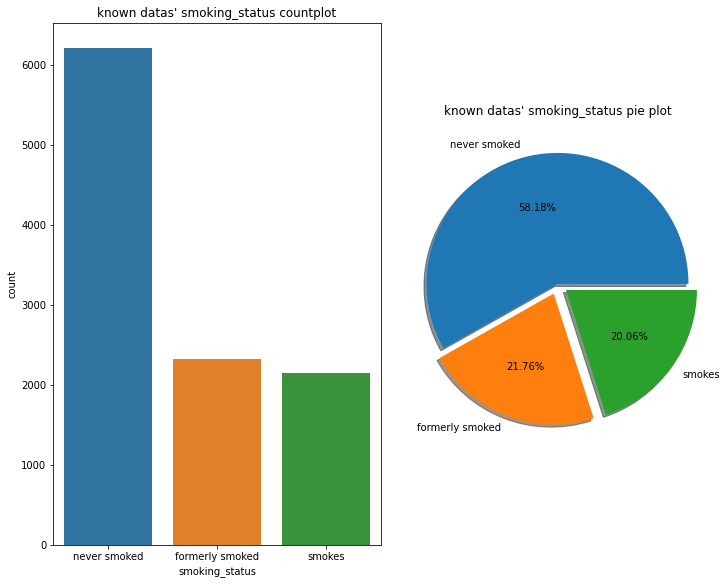

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10,8), constrained_layout = True)

sns.countplot(x='smoking_status', data=known, ax = ax[0])
ax[0].set_title("known datas' smoking_status countplot")

known['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.2f%%', ax=ax[1], shadow=True)
ax[1].set_title("known datas' smoking_status pie plot")
ax[1].set_ylabel("")

* 데이터 자체가 never smoked, formerly smoked, smokes 순으로 많음.
* known 데이터의 smoking_status의 비율과 큰 차이가 나지 않는다면 분류에 유효하지 않은 특성으로 간주.

    -> 범주형 특성에 대한 비율에 대해서 임의로 허용 오차를 5% 이내로 설정.

    ***-> 즉 never smoked가 53.18 ~ 63.18%, formerly smoked가 16.76 ~ 26.76%, smokes가 15.06 ~ 25.06% 안에 있으면 유효한 특성이 아니다.***(표본 데이터의 경향을 그대로 따라가기 때문)
    
   ***-> 허용 오차를 포함한 데이터 분석에 적용되는 통계학 공부가 필요한 부분.***

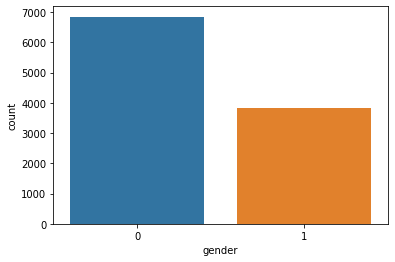

In [27]:
sns.countplot(x='gender', data=known) # 데이터 자체가 여성이 더 많다. -> 성별에 따른 비교가 어렵다. 남녀 각각의 흡연 경향을 알아봐야함.

Text(0, 0.5, '')

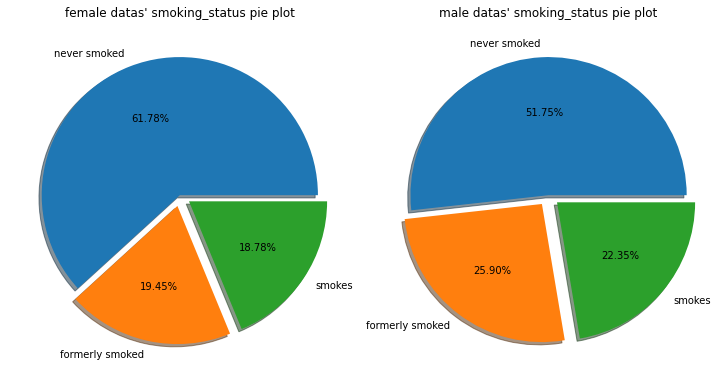

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10,15), constrained_layout = True)

known[known['gender'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.2f%%', ax=ax[0], shadow=True)
ax[0].set_title("female datas' smoking_status pie plot")
ax[0].set_ylabel("")

known[known['gender'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.2f%%', ax=ax[1], shadow=True)
ax[1].set_title("male datas' smoking_status pie plot")
ax[1].set_ylabel("")

* 여자가 흡연 무경험자의 비율이 더 높다.

* 그러나 흡연 경험 유무 자체를 놓고 본다면 남성의 경우가 흡연할 확률이 더 높다.

    **-> male 데이터와 모집단 데이터의 never smoked와의 비율 차이가 5% 이상 나므로 분류에 쓰기 좋다.**

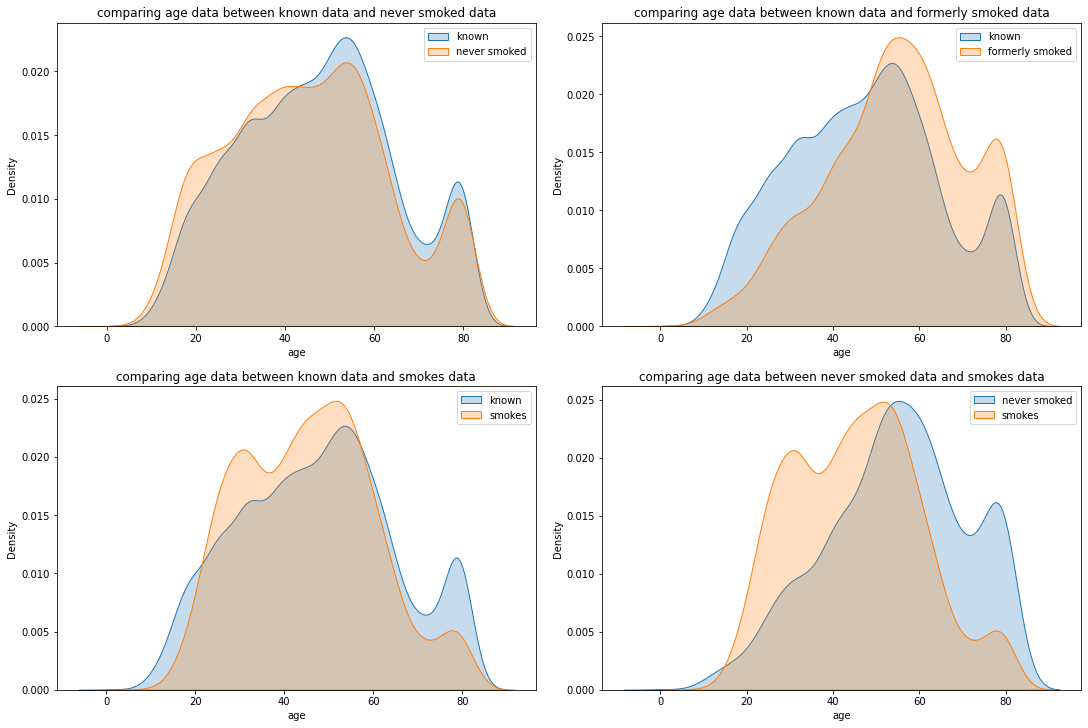

In [29]:
fig, ax = plt.subplots(2,2, figsize=(15,10), constrained_layout = True)

sns.kdeplot(known['age'], shade = True, label="known", ax = ax[0,0])
sns.kdeplot(known[known['smoking_status'] == 'never smoked']['age'], shade = True, label='never smoked', ax = ax[0,0])
ax[0,0].set_title("comparing age data between known data and never smoked data")
ax[0,0].legend()

sns.kdeplot(known['age'], shade = True, label="known", ax = ax[0,1])
sns.kdeplot(known[known['smoking_status'] == 'formerly smoked']['age'], shade = True, label='formerly smoked', ax = ax[0,1])
ax[0,1].set_title("comparing age data between known data and formerly smoked data")
ax[0,1].legend()

sns.kdeplot(known['age'], shade = True, label="known", ax = ax[1,0])
sns.kdeplot(known[known['smoking_status'] == 'smokes']['age'], shade = True, label='smokes', ax = ax[1,0])
ax[1,0].set_title("comparing age data between known data and smokes data")
ax[1,0].legend()

sns.kdeplot(known[known['smoking_status'] == 'formerly smoked']['age'], shade = True, label="never smoked", ax = ax[1,1])
sns.kdeplot(known[known['smoking_status'] == 'smokes']['age'], shade = True, label='smokes', ax = ax[1,1])
ax[1,1].set_title("comparing age data between never smoked data and smokes data")
ax[1,1].legend()

* never smoked 데이터는 전체 known 데이터와 거의 나이대 분포가 유사하다.
* formerly smoked 데이터는 전체 known 데이터보다 50대 이상의 나이대에 분포가 많다.
* smokes 데이터는 전체 known 데이터보다 20대에서 50대 사이의 나이대에 분포가 많다.

    -> 시각화한 결과를 직관적으로 판단하였을 때 smoking_status 분류에 쓰기 좋아보임.


    But, 정확한 판단 기준에 대해서 공부할 필요가 있다.
    예를 들어 어떤 두 커널 밀도 그래프가 각각 모양 자체는 큰 차이가 없어 보여도
    겹치지 않는 부분을 적분하였을 때 어느정도 차이가 나면 분류에 쓰일 수 있을 거 같다는 생각이 들기 때문

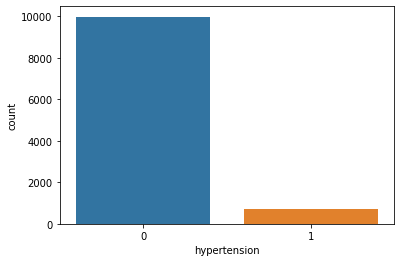

In [30]:
sns.countplot(x='hypertension', data=known)

Text(0, 0.5, '')

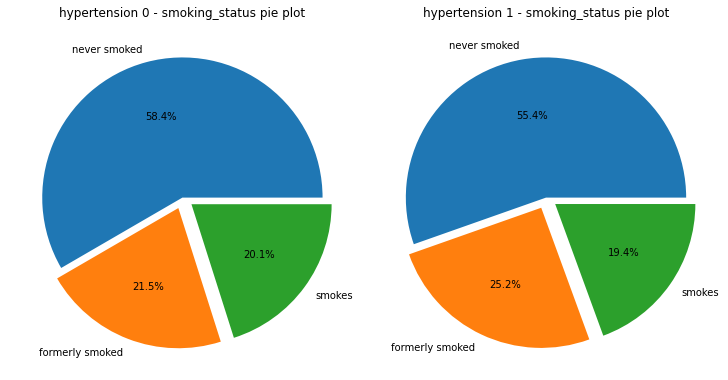

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

known[known['hypertension'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0,0.08,0.08], autopct='%.1f%%', ax = ax[0])
ax[0].set_title("hypertension 0 - smoking_status pie plot")
ax[0].set_ylabel("")

known[known['hypertension'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0,0.08,0.08], autopct='%.1f%%', ax = ax[1])
ax[1].set_title("hypertension 1 - smoking_status pie plot")
ax[1].set_ylabel("")

* 데이터 자체가 고혈압이 없는 사람이 더 많다.

* But, 고혈압 여부에 따른 흡연 양상이 큰 차이가 없다.

    **-> hypertension의 각 데이터와 모집단 데이터의 특성과의 각각의 비율 차이가 5% 이내에서 나므로 분류에 유효하지 않다.**

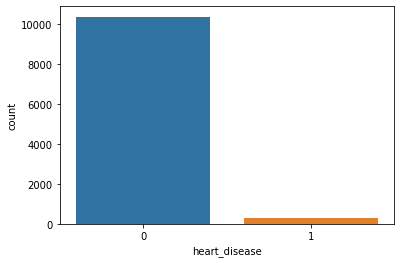

In [32]:
sns.countplot(x='heart_disease', data=known) # 데이터 자체가 심장병이 없는 사람이 더 많다.

Text(0, 0.5, '')

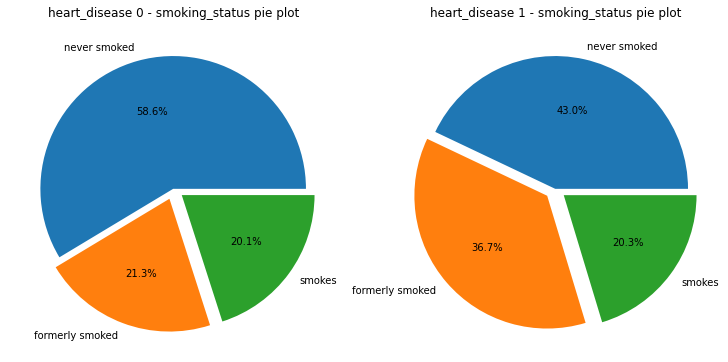

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

known[known['heart_disease'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[0])
ax[0].set_title("heart_disease 0 - smoking_status pie plot")
ax[0].set_ylabel("")

known[known['heart_disease'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1])
ax[1].set_title("heart_disease 1 - smoking_status pie plot")
ax[1].set_ylabel("")

* 심장병을 앓고 있는 사람이 심장병을 앓고 있지 않는 사람보다 이전에 흡연했을 확률이 높다.

    **-> heart_disease 1 데이터와 표본 데이터의 never smoked, formerly smoked와의 비율 차이가 5% 이상 나므로 분류에 쓰기 좋다.**

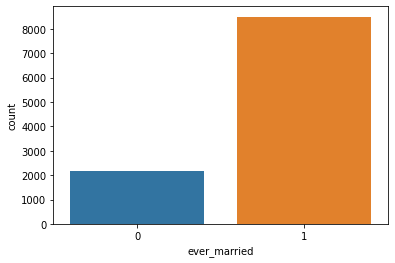

In [34]:
sns.countplot(x='ever_married', data=known) # 전체 데이터에서 결혼한 사람이 더 많다.

Text(0, 0.5, '')

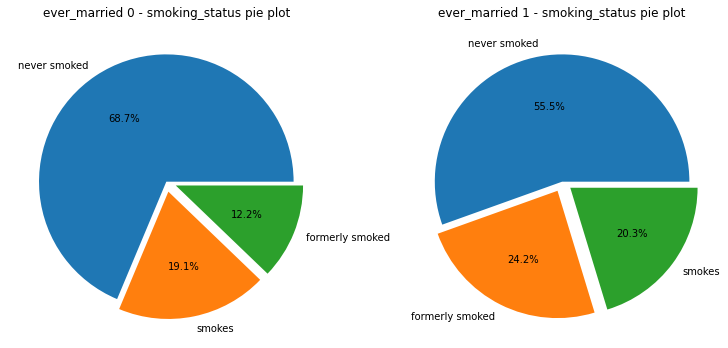

In [35]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

known[known['ever_married'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[0])
ax[0].set_title("ever_married 0 - smoking_status pie plot")
ax[0].set_ylabel("")

known[known['ever_married'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1])
ax[1].set_title("ever_married 1 - smoking_status pie plot")
ax[1].set_ylabel("")

* 결혼을 하고나서 흡연 경험이 더 많았다.

    **-> ever_married 0 데이터와 표본 데이터의 never smoked, formerly smoked와의 비율 차이가 5% 이상 나므로 분류에 쓰기 좋다.**

In [36]:
work_type_checker

,work_type
2,Private
3,Self-employed
0,Govt_job
4,children
1,Never_worked


work_type 1의 데이터 갯수는 25이다.
work_type 4의 데이터 갯수는 1641이다.


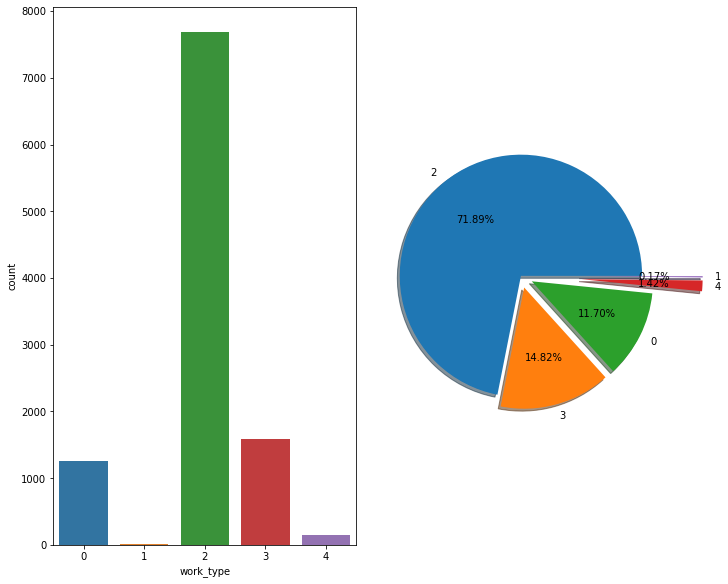

In [37]:
fig, ax = plt.subplots(1,2,figsize=(10,8), constrained_layout = True)

sns.countplot(x='work_type', data=known, ax = ax[0])

known['work_type'].value_counts().plot.pie(explode = [0, 0.1, 0.1, 0.5, 0.5], autopct='%.2f%%', ax=ax[1], shadow=True)
ax[1].set_ylabel("")

print("work_type 1의 데이터 갯수는 {}이다.".format(train[train['work_type'] == 1].shape[0]))
print("work_type 4의 데이터 갯수는 {}이다.".format(train[train['work_type'] == 4].shape[0]))

허용 오차를 고려하기 전에 특성에 의해 분류된 표본의 크기도 고려해야할 것 같다.

왜냐하면 표본의 모집단의 대부분을 차지하는 경우에는 모집단의 경향을 따라갈 수 밖에 없기 때문.

결론적으로 또 통개학 공부가 필요한 부분.

(0.0, 1.0, 0.0, 1.0)

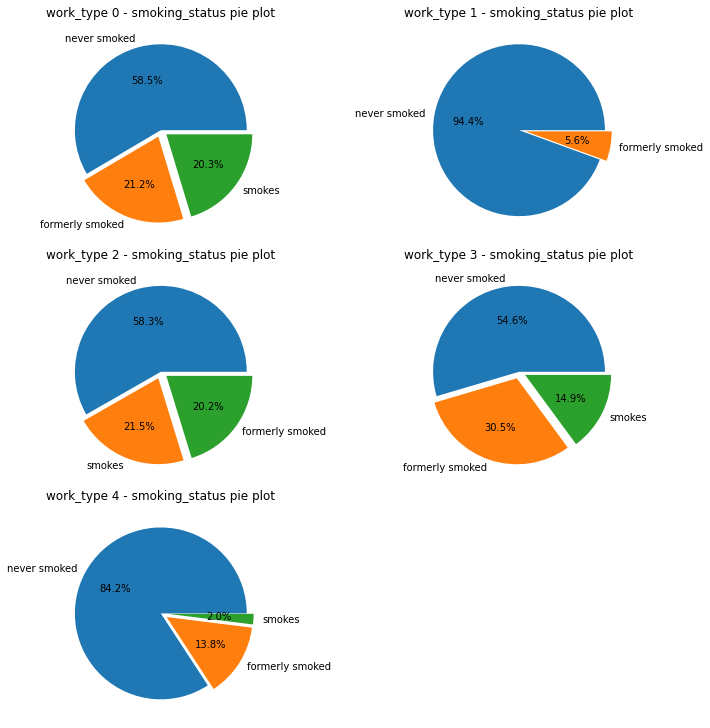

In [38]:
fig, ax = plt.subplots(3,2,figsize=(10,10), constrained_layout = True)

known[known['work_type'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[0,0])
ax[0,0].set_title("work_type 0 - smoking_status pie plot")
ax[0,0].set_ylabel("")

known[known['work_type'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08], autopct='%.1f%%', ax = ax[0,1])
ax[0,1].set_title("work_type 1 - smoking_status pie plot")
ax[0,1].set_ylabel("")

known[known['work_type'] == 2]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1,0])
ax[1,0].set_title("work_type 2 - smoking_status pie plot")
ax[1,0].set_ylabel("")

known[known['work_type'] == 3]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1,1])
ax[1,1].set_title("work_type 3 - smoking_status pie plot")
ax[1,1].set_ylabel("")

known[known['work_type'] == 4]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[2,0])
ax[2,0].set_title("work_type 4 - smoking_status pie plot")
ax[2,0].set_ylabel("")

ax[2,1].axis('off')

**-> work_type 1, 4 데이터와 표본 데이터의 각 특성 값과의 비율 차이가 5% 이상 나므로 분류에 쓰기 좋다.**

**-> work_type 3 데이터와 표본 데이터의 formerly smoked, smokes와의 비율 차이가 5% 이상 나므로 분류에 쓰기 좋다.**

Text(0, 0.5, '')

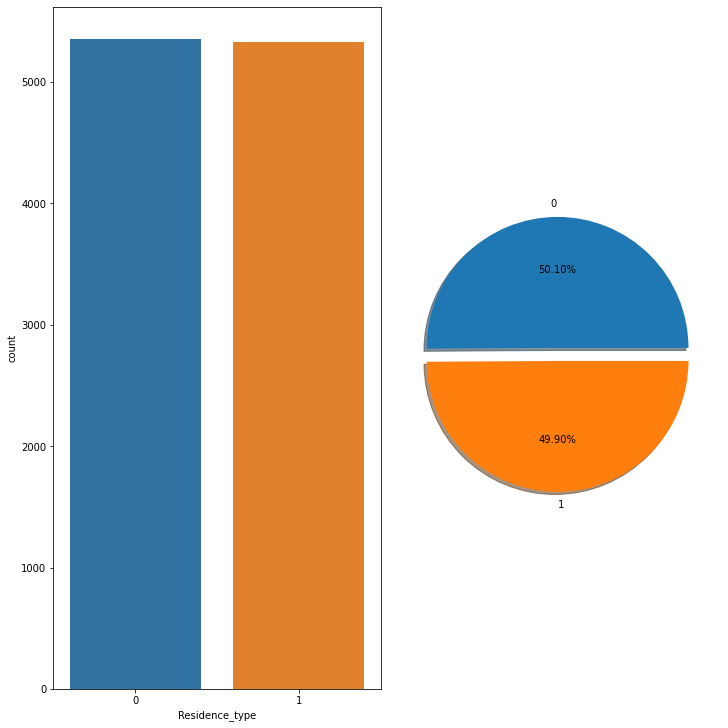

In [39]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

sns.countplot(x='Residence_type', data=known, ax = ax[0])

known['Residence_type'].value_counts().plot.pie(explode = [0, 0.1], autopct='%.2f%%', ax=ax[1], shadow=True)
ax[1].set_ylabel("")

# 각 특성값에 따른 흡연 분포가 모집단을 따라갈 것 같음.

Text(0, 0.5, '')

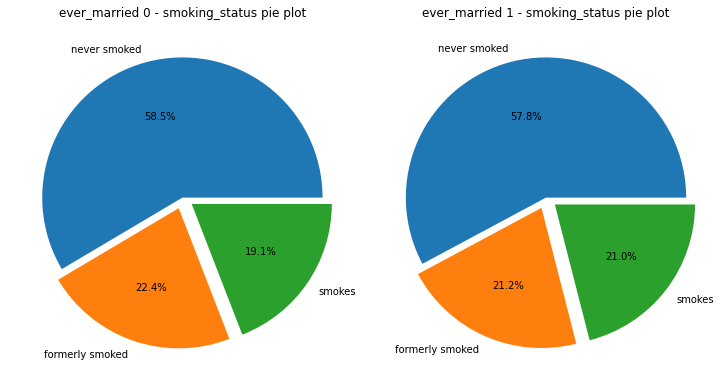

In [40]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

known[known['Residence_type'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[0])
ax[0].set_title("ever_married 0 - smoking_status pie plot")
ax[0].set_ylabel("")

known[known['Residence_type'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1])
ax[1].set_title("ever_married 1 - smoking_status pie plot")
ax[1].set_ylabel("")

**-> Residence_type의 각 데이터와 모집단 데이터의 특성과의 각각의 비율 차이가 5% 이내에서 나므로 분류에 유효하지 않다.**

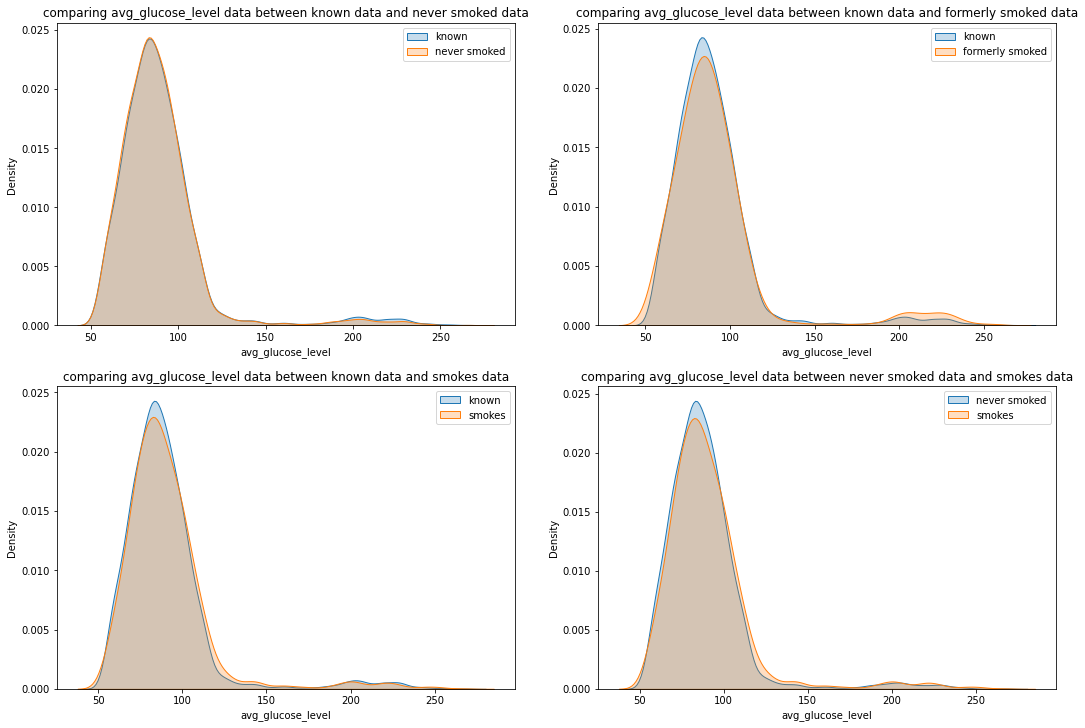

In [41]:
fig, ax = plt.subplots(2,2, figsize=(15,10), constrained_layout = True)

sns.kdeplot(known['avg_glucose_level'], shade = True, label="known", ax = ax[0,0])
sns.kdeplot(known[known['smoking_status'] == 'never smoked']['avg_glucose_level'], shade = True, label='never smoked', ax = ax[0,0])
ax[0,0].set_title("comparing avg_glucose_level data between known data and never smoked data")
ax[0,0].legend()

sns.kdeplot(known['avg_glucose_level'], shade = True, label="known", ax = ax[0,1])
sns.kdeplot(known[known['smoking_status'] == 'formerly smoked']['avg_glucose_level'], shade = True, label='formerly smoked', ax = ax[0,1])
ax[0,1].set_title("comparing avg_glucose_level data between known data and formerly smoked data")
ax[0,1].legend()

sns.kdeplot(known['avg_glucose_level'], shade = True, label="known", ax = ax[1,0])
sns.kdeplot(known[known['smoking_status'] == 'smokes']['avg_glucose_level'], shade = True, label='smokes', ax = ax[1,0])
ax[1,0].set_title("comparing avg_glucose_level data between known data and smokes data")
ax[1,0].legend()

sns.kdeplot(known[known['smoking_status'] == 'never smoked']['avg_glucose_level'], shade = True, label="never smoked", ax = ax[1,1])
sns.kdeplot(known[known['smoking_status'] == 'smokes']['avg_glucose_level'], shade = True, label='smokes', ax = ax[1,1])
ax[1,1].set_title("comparing avg_glucose_level data between never smoked data and smokes data")
ax[1,1].legend()

* 나이 데이터와 다르게 혈당 수치는 흡연 여부에 따른 kdeplot의 모양과 적분값이 큰 차이를 보이진 않았다.

    **-> smoking_status 분류에 유효해보이지 않는다.**

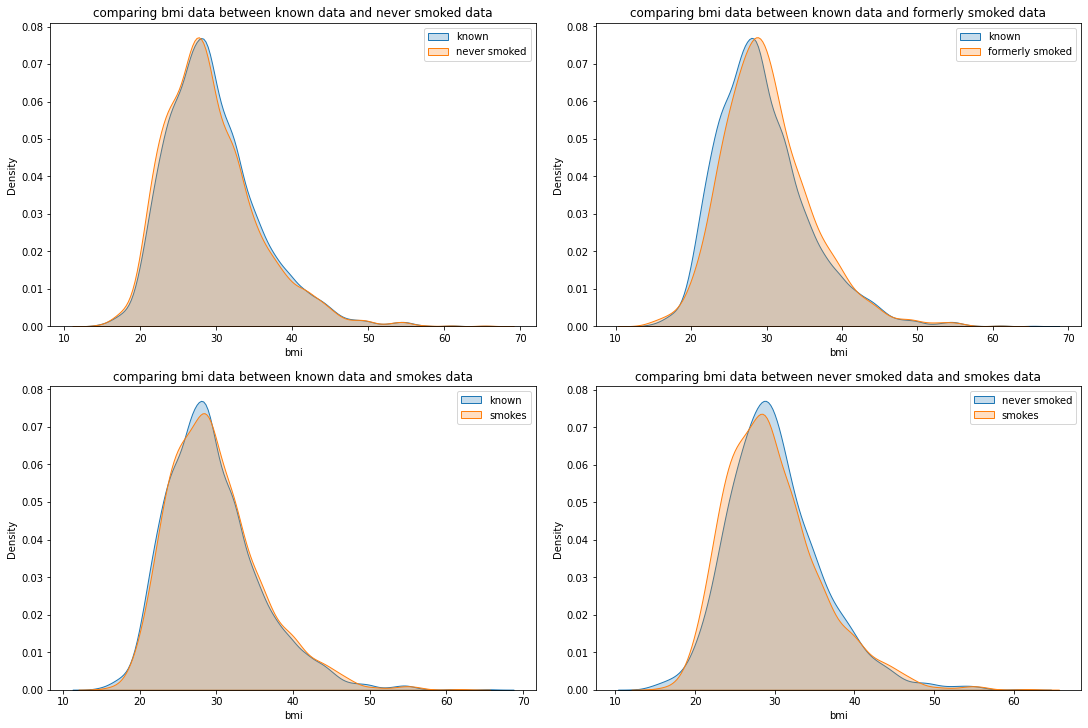

In [42]:
fig, ax = plt.subplots(2,2, figsize=(15,10), constrained_layout = True)

sns.kdeplot(known['bmi'], shade = True, label="known", ax = ax[0,0])
sns.kdeplot(known[known['smoking_status'] == 'never smoked']['bmi'], shade = True, label='never smoked', ax = ax[0,0])
ax[0,0].set_title("comparing bmi data between known data and never smoked data")
ax[0,0].legend()

sns.kdeplot(known['bmi'], shade = True, label="known", ax = ax[0,1])
sns.kdeplot(known[known['smoking_status'] == 'formerly smoked']['bmi'], shade = True, label='formerly smoked', ax = ax[0,1])
ax[0,1].set_title("comparing bmi data between known data and formerly smoked data")
ax[0,1].legend()

sns.kdeplot(known['bmi'], shade = True, label="known", ax = ax[1,0])
sns.kdeplot(known[known['smoking_status'] == 'smokes']['bmi'], shade = True, label='smokes', ax = ax[1,0])
ax[1,0].set_title("comparing bmi data between known data and smokes data")
ax[1,0].legend()

sns.kdeplot(known[known['smoking_status'] == 'formerly smoked']['bmi'], shade = True, label="never smoked", ax = ax[1,1])
sns.kdeplot(known[known['smoking_status'] == 'smokes']['bmi'], shade = True, label='smokes', ax = ax[1,1])
ax[1,1].set_title("comparing bmi data between never smoked data and smokes data")
ax[1,1].legend()

* 혈당 데이터와 비슷하게 bmi 데이터도 그래프의 모양과 크기에 대해서는 큰 차이를 보이진 않았다.

    **-> smoking_status 분류에 유효해보이지 않는다.**

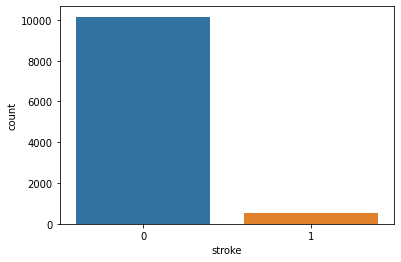

In [43]:
sns.countplot(x='stroke', data=known) # 전체 데이터에서 뇌졸중에 걸리지 않은 데이터가 더 많았다.

Text(0, 0.5, '')

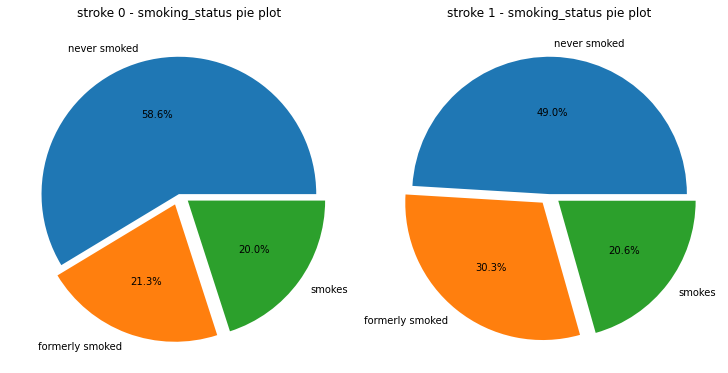

In [44]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

known[known['stroke'] == 0]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[0])
ax[0].set_title("stroke 0 - smoking_status pie plot")
ax[0].set_ylabel("")

known[known['stroke'] == 1]['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1])
ax[1].set_title("stroke 1 - smoking_status pie plot")
ax[1].set_ylabel("")

**-> stroke 1 데이터와 표본 데이터의 never smoked, formerly smoked와의 비율 차이가 5% 이상 나므로 분류에 쓰기 좋다.**


 ***허용오차 5%에서 판단한 smoking_status 분류 특성:***

'gender', 'age', 'heart_disease', 'ever_married', 'work_type', 'stroke', 'smoking_status'

In [45]:
# test_index = []

# for i in known.index:
#    if known.loc[i,'gender'] == 1 or known.loc[i,'heart_disease'] == 1 or known.loc[i,'ever_married'] == 0 or known.loc[i,'work_type'] in [1,3,4] or known.loc[i,'stroke'] == 1:
#        test_index.append(i)

# len(set(test_index))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

data = known.loc[:, ['gender', 'age', 'heart_disease', 'ever_married', 'work_type', 'stroke']].to_numpy()
target = known.loc[:, 'smoking_status']

train_input, test_input, train_target, test_target = train_test_split(data, target)

dic = {'n_estimators': [100, 200, 300, 400, 500, 600, 700],
       'max_depth' : [4, 5, 6, 7, 8, 9, 10]} 

rf = RandomForestClassifier()
gs = GridSearchCV(estimator = rf, param_grid = dic, cv = 5, scoring='accuracy')

gs.fit(train_input, train_target)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700]},
             scoring='accuracy')

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_estimators=gs.best_params_['n_estimators'], max_depth=gs.best_params_['max_depth'])
rf.fit(train_input,train_target)
pred = rf.predict(test_input)
accuracy = accuracy_score(test_target, pred)
print("랜덤 포레스트 분류 정확도는 {}이다.".format(accuracy))

# 나름대로 EDA 분석도 해보았고 그 결과 'gender', 'age', 'heart_disease', 'ever_married', 'work_type', 'stroke' 특성만 돌려봤는데도 정확도가 거의 그대로였다.
# 그래서 모델을 돌릴 때 일부러 특성 갯수를 더 줄여가면서 돌렸는데도 그대로였다. 'age', 'work_type'만 돌렸는데도 그렇게 나왔다.
# 그래서 데이터를 특정 기준을 삼아 추출한 뒤에 모델을 돌려줘야겠다는 생각까지 들었다.
# gender 1, age All, heart_disease 1, ever_married 0, work_type 1, work_type 3, work_type 4, stroke 1에 해당하는 합집합을 돌려봄.
# 기준은 시각화했을 때 모집단의 파이플롯과 차이가 직관적으로 많이 나 보이는 것.
# 그러나 이것도 오히려 정확도가 더 떨어짐.

랜덤 포레스트 분류 정확도는 0.572070385623362이다.


# 딥러닝 기반의 datawig 라이브러리 사용

(출처 : https://blog.naver.com/PostView.naver?blogId=dalgoon02121&logNo=222482929265&categoryNo=33&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)

In [ ]:
!pip install datawig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14760 entries, 0 to 14759
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             14760 non-null  int64  
 1   age                14760 non-null  int64  
 2   hypertension       14760 non-null  int64  
 3   heart_disease      14760 non-null  int64  
 4   ever_married       14760 non-null  int64  
 5   work_type          14760 non-null  int64  
 6   Residence_type     14760 non-null  int64  
 7   avg_glucose_level  14760 non-null  float64
 8   bmi                14760 non-null  float64
 9   stroke             14760 non-null  int64  
 10  smoking_status     14760 non-null  object 
dtypes: float64(2), int64(8), object(1)
memory usage: 1.2+ MB


In [ ]:
import datawig

input_columns = list(set(train.columns) - set(['smoking_status']))
imputer = datawig.SimpleImputer(input_columns=input_columns,
                                output_column='smoking_status')
imputer.fit(train_df=train, num_epochs=50)
null_train = train[train['smoking_status'] == 'NaN']
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

imputed_train[imputed_train['smoking_status_imputed_proba'] > 0.6]

INFO:root:
========== start: fit model
2023-01-27 01:47:41,160 [INFO]  
========== start: fit model
2023-01-27 01:47:41,168 [WARNING]  Already bound, ignoring bind()
INFO:root:Epoch[0] Batch [0-416]	Speed: 10382.63 samples/sec	cross-entropy=1.127312	smoking_status-accuracy=0.497752
2023-01-27 01:47:41,826 [INFO]  Epoch[0] Batch [0-416]	Speed: 10382.63 samples/sec	cross-entropy=1.127312	smoking_status-accuracy=0.497752
INFO:root:Epoch[0] Train-cross-entropy=1.111149
2023-01-27 01:47:42,481 [INFO]  Epoch[0] Train-cross-entropy=1.111149
INFO:root:Epoch[0] Train-smoking_status-accuracy=0.497368
2023-01-27 01:47:42,489 [INFO]  Epoch[0] Train-smoking_status-accuracy=0.497368
INFO:root:Epoch[0] Time cost=1.316
2023-01-27 01:47:42,493 [INFO]  Epoch[0] Time cost=1.316
INFO:root:Saved checkpoint to "smoking_status/model-0000.params"
2023-01-27 01:47:42,501 [INFO]  Saved checkpoint to "smoking_status/model-0000.params"
INFO:root:Epoch[0] Validation-cross-entropy=1.100210
2023-01-27 01:47:42,587 [

ValueError: ignored

In [ ]:
print("정확도가 이전의 랜덤포레스트와 거의 유사하거나 낮은 경우(60% 미만)의 비율 : {:.2f}%".format(imputed_train[imputed_train['smoking_status_imputed_proba'] <= 0.6].shape[0] / train.shape[0] * 100))

# Unknown 데이터 Known 데이터의 smoking_status 비율로 랜덤하게 분할

Known 데이터의 smoking_status 특성을 분석하여 Unknown 데이터를 분류하려 하였으나

정확도를 높이는 방법을 끝내 찾지 못하였고 그 부분에 대해서는 결측값 처리를 어떻게 해야할지 공부의 필요성을 느끼게 됨.

정확도가 8-90% 정도의 어느정도 납득할만한 정확도가 나오지 않아서 

Unknown 데이터를 Known 데이터의 smoking_status 비율로 랜덤하게 분할하기로 결론지음.

In [ ]:
train.columns

In [ ]:
train['id'] = train_id
train = train[['id','gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status', 'avg_glucose_level', 'bmi',  'stroke']]
train

In [ ]:
known = train[train['smoking_status'] != 'Unknown']
known.reset_index(drop = True, inplace = True)

unknown = train[train['smoking_status'] == 'Unknown']
unknown.reset_index(drop = True, inplace = True)

In [ ]:
print(known[known['smoking_status'] == 'never smoked'].shape[0] / known.shape[0] * 100, 
    known[known['smoking_status'] == 'formerly smoked'].shape[0] / known.shape[0] * 100,
    known[known['smoking_status'] == 'smokes'].shape[0] / known.shape[0] * 100)

In [ ]:
import random

unknown_indexes = list(unknown.index)

not_fullcat = 3

never_smoked_filter = int(unknown.shape[0] * 0.01 * round(known[known['smoking_status'] == 'never smoked'].shape[0] / known.shape[0] * 100))
formerly_smoked_filter = int(unknown.shape[0] * 0.01 * round(known[known['smoking_status'] == 'formerly smoked'].shape[0] / known.shape[0] * 100))

for n in range(len(unknown_indexes)):
    random_choice = random.choice(unknown_indexes)
    if unknown.loc[random_choice, "smoking_status"] != "Unknown":
        continue
    else:
        if not_fullcat == 3:
            unknown.loc[random_choice, "smoking_status"] = 'never smoked'
            unknown_indexes.remove(random_choice)
            if unknown[unknown['smoking_status'] == 'never smoked'].shape[0] == never_smoked_filter:
                not_fullcat -= 1
        elif not_fullcat == 2:
            unknown.loc[random_choice, "smoking_status"] = 'formerly smoked'
            unknown_indexes.remove(random_choice)
            if unknown[unknown['smoking_status'] == 'formerly smoked'].shape[0] == formerly_smoked_filter:
                not_fullcat -= 1
        else:
            unknown.loc[unknown_indexes, "smoking_status"] = 'smokes'
            break

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,10), constrained_layout = True)

known['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[0])
ax[0].set_title("known smoking_status pie plot")
ax[0].set_ylabel("")

unknown['smoking_status'].value_counts().plot.pie(explode = [0, 0.08, 0.08], autopct='%.1f%%', ax = ax[1])
ax[1].set_title("unknown smoking_status pie plot")
ax[1].set_ylabel("")

In [ ]:
train = pd.concat([known, unknown])
train = train.sort_values('id')
train.reset_index(drop = True, inplace = True)
train

In [ ]:
from sklearn.preprocessing import LabelEncoder

smoking_status_answer = train['smoking_status'].unique()
encoder = LabelEncoder()
encoder.fit(smoking_status_answer)
train['smoking_status'] = encoder.transform(train['smoking_status'])
print(smoking_status_answer, encoder.transform(smoking_status_answer))

* 정제된 전체 데이터를 갖고 EDA 분석해줘야함...

# Stroke EDA 분석

* 뇌졸중의 주요 원인 (출처 : https://www.stroke.or.kr/stroke/?doc=3#c1)
    1. 고혈압

    2. 당뇨병 : [정상치] 70~99 ㎎/ℓ 8시간 이상 공복 후 측정한 혈당이 126 mg/dL 이상인 경우 당뇨병으로 진단이 됩니다. 
    
    (출처 : https://www.kslm.org/sub01/sub03.html)

    3. 심장병

    4. 고지혈증 (데이터에 관련 정보 없음)

    5. 흡연

    6. 음주 (데이터에 관련 정보 없음)

    7. 비만 :  WHO(Asia-Pacific Region) 와 대한비만학회에서 비만의 기준은 체질량지수 25kg/㎡ 이상으로 정의하였다.

    (출처 : https://dietitian.or.kr/work/business/kb_c_adult_obesity_verdict.do)

